## FIM simulation of Platinum

In [1]:
import netCDF4
from pyiron import Project
import numpy as np
import h5py
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from pyiron_base import load


In [2]:
import sys
sys.path.append ('/cmmc/u/sbhatt/pyiron/my_module/EXTRA_git')
import Extracode.main as nm


/cmmc/u/sbhatt/pyiron/my_module/EXTRA_git/Extracode/main.py:309: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _fillin(res, psire, psiim, fft_idx):


In [3]:
pr = Project ('Platinum')

## First we get DFT wavefunctions and Potential from another directory
sphinx waves are not added here due to the significant size in gigabytes.
total_V is total potential i.e sum of elctrostatic and exchange correlation potential; 
V1 is average potential 

In [4]:
working_directory="/u/skatnagallu/pyiron/projects/HEA_FIM/PtIrAu_FIM_contrast/Pt_210_relax_wf_doubley_4_0_VA_hdf5/Pt_210_relax_wf_doubley_4_0_VA"

dft= nm.sx_waves_reader(working_directory,working_directory+'/waves.sxb')
potentials=nm.potential(working_directory)
total_V,V1,cell= potentials.potential_cell()


In [5]:
total_V.shape

(60, 56, 220)

In [6]:
 Simulator = {
            'working_directory': '/u/skatnagallu/pyiron/projects/HEA_FIM/PtIrAu_FIM_contrast/Pt_210_relax_wf_doubley_4_0_VA_hdf5/Pt_210_relax_wf_doubley_4_0_VA',
            'ik': 0,
            'z_max': 40,
            'izstart_min': 115,
            'izend': 100,
            'cutoff': 10,
            'limit': 1e-10,
            'E_fermi': 52.1157 ,
            'E_max': 57.0034,
            'ionization_energies': [10., 15., 21.5]
    }

In [8]:
x_1D= np.linspace(0,cell[0,0],total_V.shape[0])
dx=x_1D[1]-x_1D[0]
y_1D= np.linspace(0,cell[1,1],total_V.shape[1])
dy=y_1D[1]-y_1D[0]
z_1D= np.linspace(0,cell[2,2],total_V.shape[2])
dz=z_1D[1]-z_1D[0]
ispin=0
i=380
ik=0
z_max=40
Nz_max= int(z_max/dz)
waves=nm.extra_waves(total_V,dz,cell,Nz_max,dft,inputDict=Simulator)
psi_real,psi_extra,gk_1,gk_2 = waves.get_psi(i,ispin,ik)

## plot EXTRA  and DFT wavefunctions along z

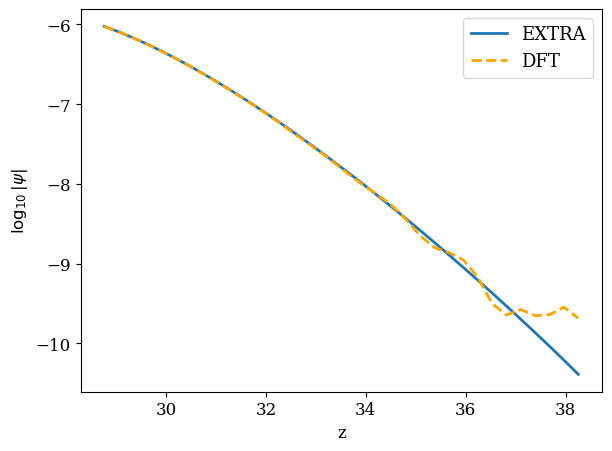

In [11]:
plt.plot (z_1D[Simulator["izend"]:Nz_max-5],np.log10(np.abs(psi_extra[28,26,Simulator["izend"]:Nz_max-5])),label='EXTRA',linewidth=2.0)
plt.plot (z_1D[Simulator["izend"]:Nz_max-5],np.log10(np.abs(psi_real[28,26,Simulator["izend"]:Nz_max-5])),'--',color='orange',label='DFT',linewidth=2.0)

plt.xlabel('z',fontsize=12)
plt.ylabel('$\log_{10} |\psi|$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] ='serif'
#plt.xlim((22,34))
plt.tight_layout()

plt.legend(fontsize=13)



In [12]:
fim=nm.FIM_simulations(dft,psi_extra,total_V,inputDict=Simulator)
fim.sum_all_states(ik)

In [13]:
all_totals = dict ()
Nx,Ny=60,56
for ik in range(25):
        with h5py.File(f'/cmmc/u/sbhatt/pyiron/my_module/Platinum/purePt{ik}_hdf5/purePt{ik}/partial_dos0.h5', 'r') as handle:
            for varname in handle.keys ():
                if 'IE=' in varname:
                    IE = float(str(varname).replace('IE=',''))
                    if IE not in all_totals.keys ():
                        all_totals[IE] = np.zeros((Nx,Ny), dtype=np.float64)
                    all_totals[IE] += np.asarray(handle[varname])

In [14]:
xp =np.linspace(0,27,270)
yp= np.linspace(0,18,180)
FIM_image_ex_all=np.zeros([xp.shape[0],yp.shape[0]],dtype=np.complex128)

# interpolation of DFT_total3
prho_rec_ex_all= np.fft.ifft2(all_totals[21.5])
for ix in range(xp.shape[0]):
    for iy in range(yp.shape[0]):
        x=xp[ix]
        y=yp[iy]
        phase_1=np.exp(-1j*(gk_1[:,0]*x+gk_1[:,1]*y))
        phase_2= np.exp(-1j*(gk_2[:,0]*x+gk_2[:,1]*y))
        phase=np.outer(phase_1,phase_2)
        FIM_image_ex_all[ix,iy] =np.sum(prho_rec_ex_all.flatten()*phase.flatten())

1.362924437128936e-19
1e-19
1.4e-19


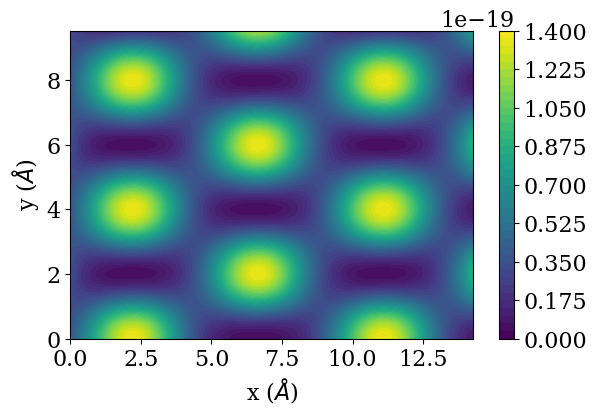

In [15]:
vmax=np.max(FIM_image_ex_all.real)
print(vmax)
vmax_lev=np.power(10., np.trunc(np.log10(vmax))-1)
print(vmax_lev)
vmax_lev=(np.trunc(vmax / vmax_lev * 10.)+1)*0.1 * vmax_lev
print(vmax_lev)
plt.figure(figsize=[6.5,4])
plt.contourf(xp/1.89,yp/1.89,FIM_image_ex_all.real.T,vmin=0,vmax=vmax_lev,levels=np.linspace(0,vmax_lev,41))
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] ='serif'
plt.xlabel('x ($\AA$)')
#plt.xticks([0,5,10,15,20,25])
plt.ylabel('y ($\AA$)')
plt.colorbar()
#toplayer=[(x / BOHR_TO_Angstrom,y/ BOHR_TO_Angstrom) for x,y,z in struct.positions  if z>10]
#for (x,y) in toplayer[0:8]:
 #   plt.text(x,y, 'Ni', style='normal',fontsize=14,color='white')
#plt.text(toplayer[8][0],toplayer[8][1], 'Re', style='normal',fontsize=14,color='black')
#plt.figtext(0.12, 0.8, 'EXTRA (I=21.5 eV)',color='white')
plt.savefig("purept_EXTRA.png",bbox_inches="tight", dpi=400)